In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import collections

In [27]:
class GridWorld:
    
    """Gridworld as MDP"""
    def __init__(self, m, n):
        """ initializes the gridworld
        """
        self.m = m
        self.n = n
        self.grid = np.zeros(shape = (m,n))
        self.end = False
        self.goal_tile = 60
        self.wall_tile = 100
        self.ice_tile = 30
        self.figure = 0
        self.free_tile = 230
        # fill the grid with free tiles
        for i in range(self.m):
            for j in range(self.n):
                self.grid[i,j] = self.free_tile
        # possible actions
        self.actions = ["up", "down", "right", "left"]

        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
    
        self.grid[1][1] = self.ice_tile
        self.grid[1][4]= self.ice_tile
        self.grid[1][3] = self.wall_tile
        
    def reset(self):
        """ resets the gridworld
        """
        self.end = False
        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
        
        self.grid[1][1] = self.ice_tile
        self.grid[1][4] = self.ice_tile

    def __getitem__(self, grid):
        """ returns the grid

        Args:
            grid (np_array): gridworld
        """
        print(self.grid)
        return self.grid

    # a function that returns the four tiles that are visible to the agent
    def visible_tiles(self):
        """ returns the four tiles that are visible to the agent
        """
        x,y = self.current_pos()
        visible_tiles = []
        for i in self.actions:
            next, next_two, con, con2 = self.action_parameter(i)
            if con == True:
                visible_tiles.append(self.grid[next])
        return visible_tiles
        
    def visualize_grid(self):
        """ visualizes the gridworld
        """
        fig, ax = plt.subplots()
        ax.matshow(self.grid, cmap = 'Pastel1')
        for i in range(self.grid.shape[1]):
            for j in range(self.grid.shape[0]):
                # create a string for the label of each tile in the right format
                if str(self.grid[j,i]) == str(float(self.free_tile)):
                    label = " "
                elif str(self.grid[j,i]) == str(float(self.wall_tile)):
                    label = "wall"
                elif str(self.grid[j,i]) == str(float(self.ice_tile)):
                    label = "ice"
                elif str(self.grid[j,i]) == str(float(self.goal_tile)):
                    label = "goal"
                elif str(self.grid[j,i]) == str(float(self.figure)):
                    label = "agent"
                else:
                    label = str(self.grid[j,i])
                ax.text(i, j, label, va = 'center', ha = 'center')
        plt.show()

    def current_pos(self):
        """ returns the current position of the agent
        """
        found = False
        for x in range(self.m):
            for y in range(self.n):
                if self.grid[x,y] == self.figure:
                    found = True
                    break
            if found == True:
                break
        return x,y
    
    def action_parameter(self, action):
        """ returns the next tile and the tile after the next tile and if the next tile is in the grid

        Args:
            action (str): action that the agent should take
        """
        x, y = self.current_pos()
        con = False
        con2 = False
        if action == "up":
            next = x-1,y
            next_two = x-2,y
            if x-1 >= 0:
                con = True
            if x-2 >= 0:
                con2 = True

        elif action == "down":
            next = x+1,y
            next_two = x+2,y
            if x+1 <= self.m-1:
                con = True
            if x+2 <= self.m-1:
                con2 = True

        elif action == "right":
            next = x,y+1
            next_two = x,y+2
            if y+1 <= self.n-1:
                con = True
            if y+2 <= self.n-1:
                con2 = True
        elif action == "left":
            next = x,y-1
            next_two = x,y-2
            if y-1 >= 0:
                con = True
            if y-2 >= 0:
                con2 = True
        return next, next_two, con, con2
            
    def move(self, action):
        """ move the agent according to the action

        Args:
            action (str):  action that the agent should take
        """
        if action != None:
            next, next_two, con, con2 = self.action_parameter(action)
            x, y = self.current_pos()
            if con == True:
                self.grid[x,y] = self.free_tile
                # if the agent reaches the goal, the game ends
                if self.grid[next] == self.goal_tile:
                    # self.grid[next] = self.figure
                    self.end = True
                # if the agent reaches an icy tile, it moves two steps left
                elif self.grid[next] == self.ice_tile and con2 == True:
                    if self.grid[next_two] == self.goal_tile:
                        # self.grid[next_two] == self.figure
                        self.end = True
                    elif self.grid[next_two] == self.wall_tile:
                        self.grid[next] = self.figure
                    else:
                        self.grid[next_two] = self.figure          
                # if the agent reaches a wall, it cannot move
                elif self.grid[next] == self.wall_tile:
                    self.grid[x,y] = self.figure
                elif self.grid[next] == self.free_tile:
                    self.grid[next] = self.figure

    def get_reward(self, next):
        """ Returns the reward of the agent

        Args:
            next (tuple): next position of the agent
        """
        if next == self.goal_tile:
            return 100
        else:
            return -1

    def initialize_policy(self):
        """ Initializes the policy of the agent
        """
        policy = np.zeros(shape = (self.m, self.n, len(self.actions)))
        for i in range(self.m):
            for j in range(self.n):
                for k in range(len(self.actions)):
                    policy[i,j,k] = 1/len(self.actions)
        return policy




    
    def policy_evaluation(self, grid, policy, value):
        """ Policy evaluation function for the policy iteration algorithm

        Args:
            grid (np_array): grid of the environment
            policy (np_array): policy of the agent
            value (np_array): value function of the agent
        """
        # with convergence and for the policy iteration in the function mc_estimation
        for i in range(self.m):
            for j in range(self.n):
                grid[i,j] = self.grid[i,j]
        # initialize delta
        delta = 1
        # while delta is greater than the threshold
        while delta > 0.01:
            delta = 0
            # for all states
            for i in range(self.m):
                for j in range(self.n):
                    # keep the old value
                    old_value = value[i,j]
                    # initialize the new value
                    new_value = 0
                    # for all actions
                    for k in range(len(self.actions)):
                        # get the next tile and the tile after the next tile
                        next, next_two, con, con2 = self.action_parameter(self.actions[k])
                        # if the next tile is in the grid
                        if con == True:
                            # update the new value
                            new_value += policy[i,j,k] * (self.get_reward(next) + 0.9 * value[next])
                    # update the value function
                    value[i,j] = new_value
                    # update delta
                    delta = max(delta, abs(old_value - value[i,j]))
        return value

    def policy_improvement(self, grid, policy, value, data):
        """Policy improvement step of policy iteration algorithm

        Args:
            grid (np_array): grid of the environment
            policy (np_array): policy of the agent
            value (np_array): value function of the agent
        # """
        policy_stable = True
        # for all states
        for i in range(self.m):
            for j in range(self.n):
                # keep the old action
                old_action = np.argmax(policy[i,j])
                # initialize the new action
                new_action = 0
                # initialize the new value
                new_value = 0
                # for all actions
                for k in range(len(self.actions)):
                    # get the next tile and the tile after the next tile
                    next, next_two, con, con2 = self.action_parameter(self.actions[k])
                    # if the next tile is in the grid
                    if con == True:
                        # update the new value
                        new_value += policy[i,j,k] * (self.get_reward(next) + 0.9 * value[next])
                # update the action
                new_action = np.argmax(new_value)
                # update the policy
                policy[i,j,old_action] = 0
                policy[i,j,new_action] = 1
                # if the policy is not stable
                if old_action.all() != new_action:
                    policy_stable = False
        return policy, policy_stable


    def mc_estimation(self, num_episodes, gamma, epsilon):
        """Monte Carlo estimation

        Args:
            num_episodes (int): number of episodes
            gamma (int): discount factor
            epsilon (int): epsilon
        """
        # initialize the value function
        value = np.zeros(shape = (self.m, self.n))
        # initialize the policy
        policy = self.initialize_policy()
        #Q = np.zeros(shape = (self.m, self.n, len(self.actions)))
        average_returns = []
        # time
        time_per_episode = []
        returns = {}
        list = []
        
        for i in tqdm(range(num_episodes)):
            # initialize the episode
            G = 0
            episode = []
            seen_states = []
            self.end = False
            policy_stable = False
            rewards = []
            # returns = {}
            self.reset()
            # time each episode
            time_start = time.time()
            # loop over the episode
            while self.end == False:
                # choose an action
                old_position = self.current_pos
                action = np.random.choice(self.actions, p = policy[self.current_pos()])

                # take the action and observe the next state and reward
                self.move(action)
                # add the state to the episode
                episode.append((self.current_pos(), action, self.get_reward(self.grid[self.current_pos()])))
                # check if the episode is done
                if self.current_pos() == self.goal_tile:
                    self.end = True
                # add the reward to the rewards list
                rewards.append(self.get_reward(self.grid[self.current_pos()]))
            # end time
            time_end = time.time()
            # calculate the time
            time_episode = time_end - time_start
            # add the time to the time list
            time_per_episode.append(time_episode)
            
            # loop over the episode
            for j in range(len(episode)):
                # get the state, action and reward
                state, action, reward = episode[j]
                # calculate the return
                G = gamma * G + reward
                # if the state is not in the returns dictionary
                if state not in returns:
                    returns[state] = []
                # add the return to the returns dictionary
                returns[state].append(G)
                # calculate the average return
                average_return = np.mean(returns[state])
                # add the average return to the list
                list.append(G)
                
                # update the value function
                value[state] = average_return   
                
                # update the policy 
                for k in range(len(self.actions)):
                    if k == action:
                        policy[state[0], state[1], k] = 1 - epsilon + epsilon / len(self.actions)
                    else:
                        policy[state[0], state[1], k] = epsilon / len(self.actions)


            # add the average return to the list
            average_returns.append(np.mean(list))
            list.clear()

            # normalize the policy
            for l in range(len(policy)):
                for j in range(len(policy[l])):
                    policy[l,j] = policy[l,j] / np.sum(policy[l,j])

            epsilon = epsilon * 0.99    
                          
        return policy, returns, value, average_returns, time_per_episode

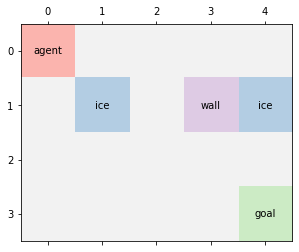

  0%|          | 0/1000 [00:00<?, ?it/s]

[[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]]
[[-11.10501575 -12.3143992  -13.50962373 -14.32421503 -14.65274373]
 [-12.24462165   0.         -13.45826479   0.           0.        ]
 [-13.4863863  -13.70197373 -14.12821293 -14.71833957 -14.93391972]
 [-14.13708148 -14.27963624 -14.57795789 -14.77150161  86.0677145 ]]


In [28]:
env = GridWorld(4,5)
env.visualize_grid()
policy = env.initialize_policy()
policy, returns, value, average_returns, time_episode = env.mc_estimation(1000, 0.94, 0.1)
print(policy)
print(value)
# self.actions = ["up", "down", "right", "left"]

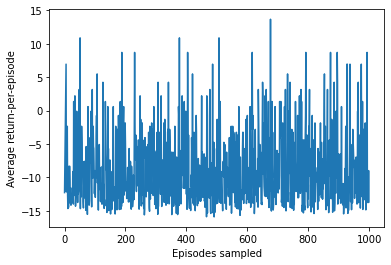

In [29]:
#visualize average return-per-episode in episodes-sampled
x = list(range(1000))
# print(average_returns)
y = average_returns
# print(average_returns)
plt.plot(x,y)
plt.xlabel('Episodes sampled')
plt.ylabel('Average return-per-episode')
plt.show()

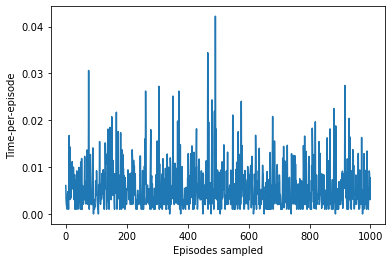

In [30]:
# visualize the time-per-episode in episodes-sampled
x = list(range(1000))
y = time_episode
plt.plot(x,y)
plt.xlabel('Episodes sampled')
plt.ylabel('Time-per-episode')
plt.show()
